# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=8666d62b-31ed-4081-b6c5-4d7f2f94e133
To: /home/steph/Documents/Learning/Constructor/code/brain-project/challenge/notebooks/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:07<00:00, 19.9MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152504
-rw-rw-r-- 1 steph steph    350479 Apr  4 10:11 Brain_Tumor_Detector_Helper_SK.ipynb
-rw-rw-r-- 1 steph steph 155791278 Apr  4 10:42 brain_tumor.zip
-rw-rw-r-- 1 steph steph      7925 Dez  7  2021 template_notebook.ipynb
drwxrwxr-x 6 steph steph      4096 Apr  4 10:51 Testing/
drwxrwxr-x 6 steph steph      4096 Apr  4 10:52 Training/


In [5]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

[sudo] password for steph: 


In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/  [error opening dir]

0 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ../data/raw/Testing/ #just to see folder structures, run only on linux systems like colab

../data/raw/Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

2024-04-04 10:55:40.744096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:55:40.744128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:55:40.759916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 10:55:40.784783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF Version: 2.15.0


## Utility functions to create dataset generators

In [15]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "../data/raw/Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [16]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2024-04-04 11:02:23.742997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 11:02:23.854576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 11:02:23.854838: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


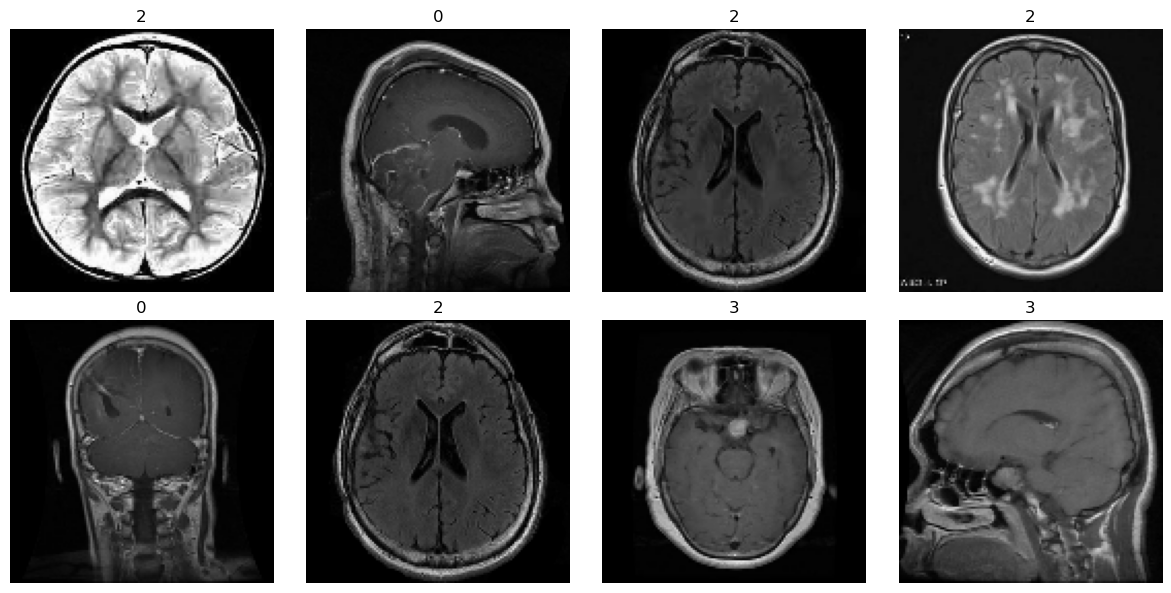

In [17]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
                        
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [19]:
# create a simple CNN model as baseline

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)       

Epoch 1/10


2024-04-04 11:25:49.923640: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-04 11:25:50.515181: I external/local_xla/xla/service/service.cc:168] XLA service 0x72ddd435c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 11:25:50.515207: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-04-04 11:25:50.528598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712222750.624311   92389 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 [==============================] - 5s 19ms/step - loss: 0.6851 - accuracy: 0.7175 - val_loss: 0.6346 - val_accuracy: 0.7539
Epoch 2/10
143/143 [==============================] - 2s 13ms/step - loss: 0.3916 - accuracy: 0.8545 - val_loss: 0.3197 - val_accuracy: 0.8967
Epoch 3/10
143/143 [==============================] - 2s 13ms/step - loss: 0.2727 - accuracy: 0.9007 - val_loss: 0.2816 - val_accuracy: 0.9037
Epoch 4/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1820 - accuracy: 0.9359 - val_loss: 0.2628 - val_accuracy: 0.9291
Epoch 5/10
143/143 [==============================] - 2s 13ms/step - loss: 0.1214 - accuracy: 0.9586 - val_loss: 0.2434 - val_accuracy: 0.9335
Epoch 6/10
143/143 [==============================] - 2s 13ms/step - loss: 0.0745 - accuracy: 0.9753 - val_loss: 0.2436 - val_accuracy: 0.9370
Epoch 7/10
143/143 [==============================] - 2s 13ms/step - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.2445 - val_accuracy: 0.9387
Epoch 8/10

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:03,  2.82it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  6.22it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  7.87it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  8.95it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.69it/s]

1/1 [==============================] - 0s 254ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  7.37it/s]

              precision    recall  f1-score   support

      glioma       0.92      0.95      0.93       300
  meningioma       0.93      0.87      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



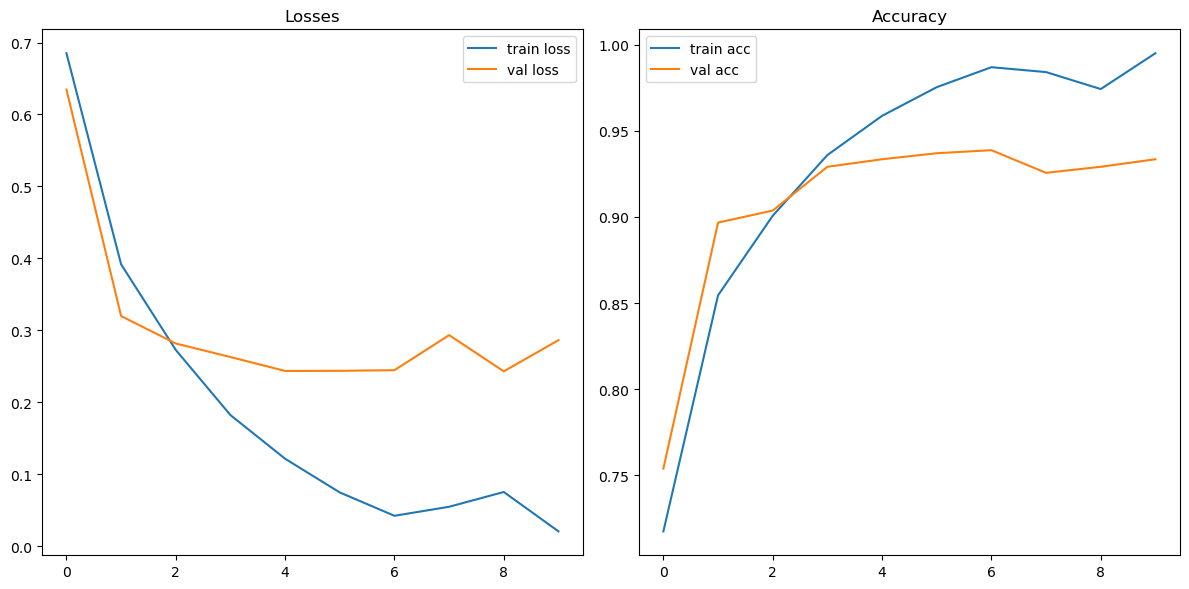

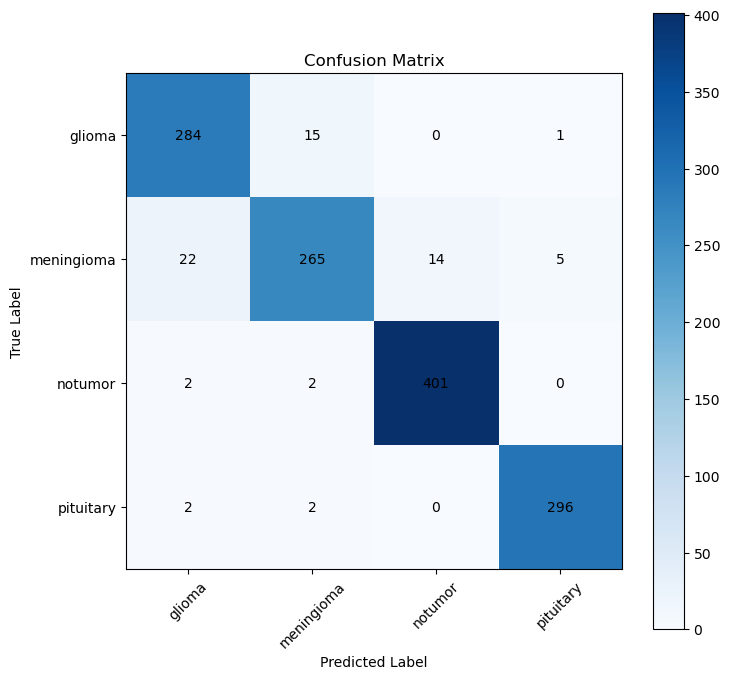

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# tarin the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier.h5')



In [21]:
# add augmentation directly to the training set like:

train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))



Epoch 1/10
143/143 [==============================] - 4s 13ms/step - loss: 0.2932 - accuracy: 0.9048 - val_loss: 0.4845 - val_accuracy: 0.8739
Epoch 2/10
143/143 [==============================] - 3s 12ms/step - loss: 0.1665 - accuracy: 0.9457 - val_loss: 0.2473 - val_accuracy: 0.9177
Epoch 3/10
143/143 [==============================] - 3s 12ms/step - loss: 0.1414 - accuracy: 0.9525 - val_loss: 0.3678 - val_accuracy: 0.9098
Epoch 4/10
143/143 [==============================] - 3s 12ms/step - loss: 0.0933 - accuracy: 0.9705 - val_loss: 0.2970 - val_accuracy: 0.9352
Epoch 5/10
143/143 [==============================] - 3s 13ms/step - loss: 0.0659 - accuracy: 0.9803 - val_loss: 0.3649 - val_accuracy: 0.9405
Epoch 6/10
143/143 [==============================] - 3s 12ms/step - loss: 0.0635 - accuracy: 0.9801 - val_loss: 0.3817 - val_accuracy: 0.9256
Epoch 7/10
143/143 [==============================] - 3s 12ms/step - loss: 0.0584 - accuracy: 0.9816 - val_loss: 0.3287 - val_accuracy: 0.9378

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:02,  3.61it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  7.05it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  8.58it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:00<00:00,  8.58it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  8.91it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:00<00:00,  9.09it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.32it/s]

1/1 [==============================] - 0s 16ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  8.98it/s]


              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.93      0.90      0.92       306
     notumor       0.93      0.99      0.96       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.95      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



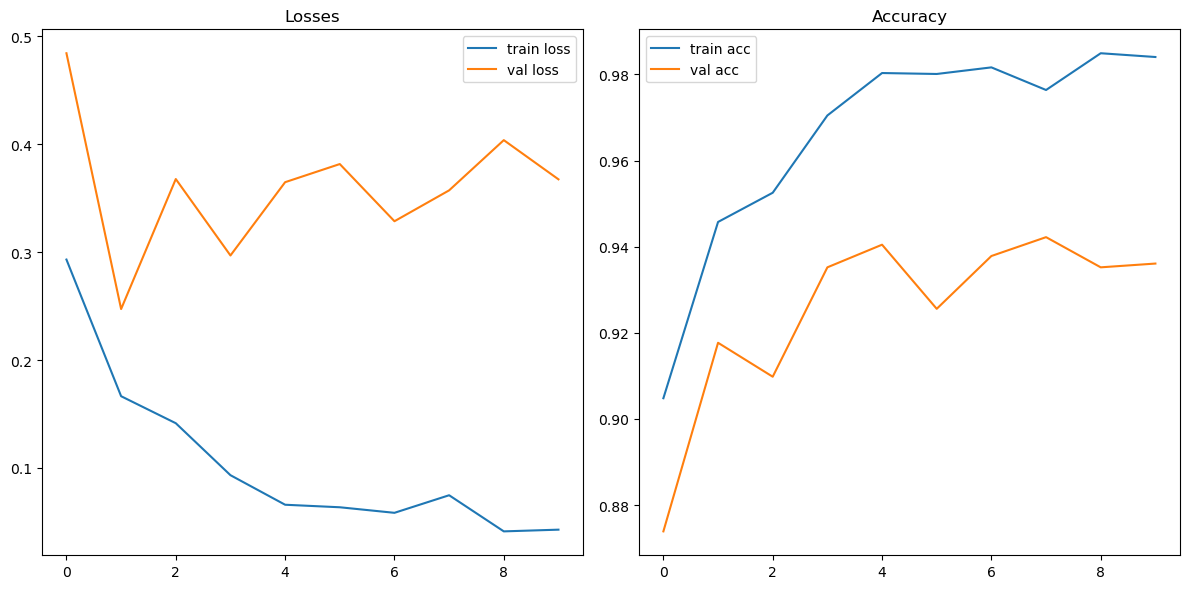

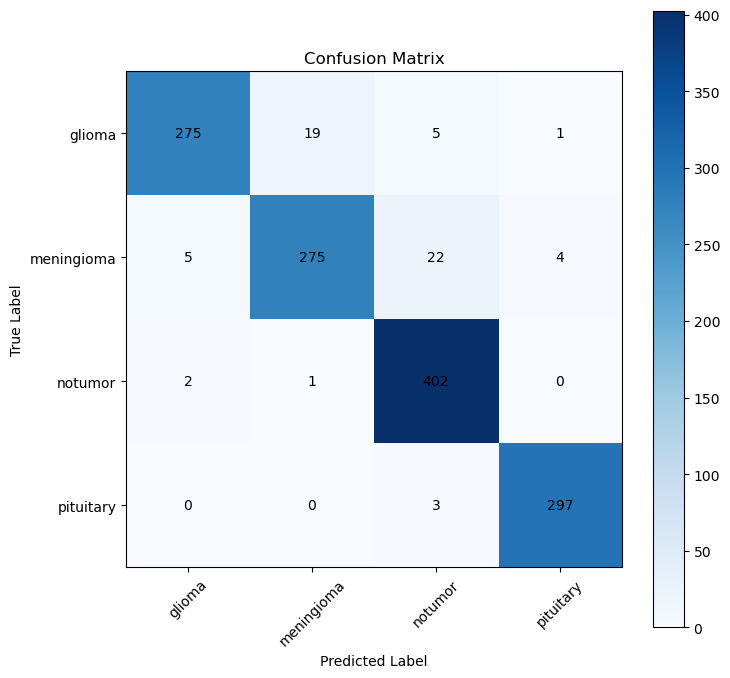

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_1.h5')

In [26]:
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                    .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.5), label))
                    .map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))


Epoch 1/10
143/143 [==============================] - 5s 12ms/step - loss: 0.5229 - accuracy: 0.8304 - val_loss: 0.4202 - val_accuracy: 0.9124
Epoch 2/10
143/143 [==============================] - 5s 12ms/step - loss: 0.2914 - accuracy: 0.9022 - val_loss: 0.2886 - val_accuracy: 0.9440
Epoch 3/10
143/143 [==============================] - 5s 13ms/step - loss: 0.2974 - accuracy: 0.8906 - val_loss: 0.3236 - val_accuracy: 0.9264
Epoch 4/10
143/143 [==============================] - 5s 13ms/step - loss: 0.2150 - accuracy: 0.9304 - val_loss: 0.2974 - val_accuracy: 0.9431
Epoch 5/10
143/143 [==============================] - 5s 13ms/step - loss: 0.2650 - accuracy: 0.9112 - val_loss: 0.3176 - val_accuracy: 0.9361
Epoch 6/10
143/143 [==============================] - 5s 13ms/step - loss: 0.1618 - accuracy: 0.9453 - val_loss: 0.2888 - val_accuracy: 0.9457
Epoch 7/10
143/143 [==============================] - 5s 13ms/step - loss: 0.1677 - accuracy: 0.9411 - val_loss: 0.3748 - val_accuracy: 0.9475

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:00<00:02,  3.40it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:00<00:01,  6.97it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:00<00:00,  8.54it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:00<00:00,  9.31it/s]

4/4 [==============================] - 0s 3ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:01<00:00,  9.91it/s]

1/1 [==============================] - 0s 16ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:01<00:00,  9.33it/s]

              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.93      0.90      0.91       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



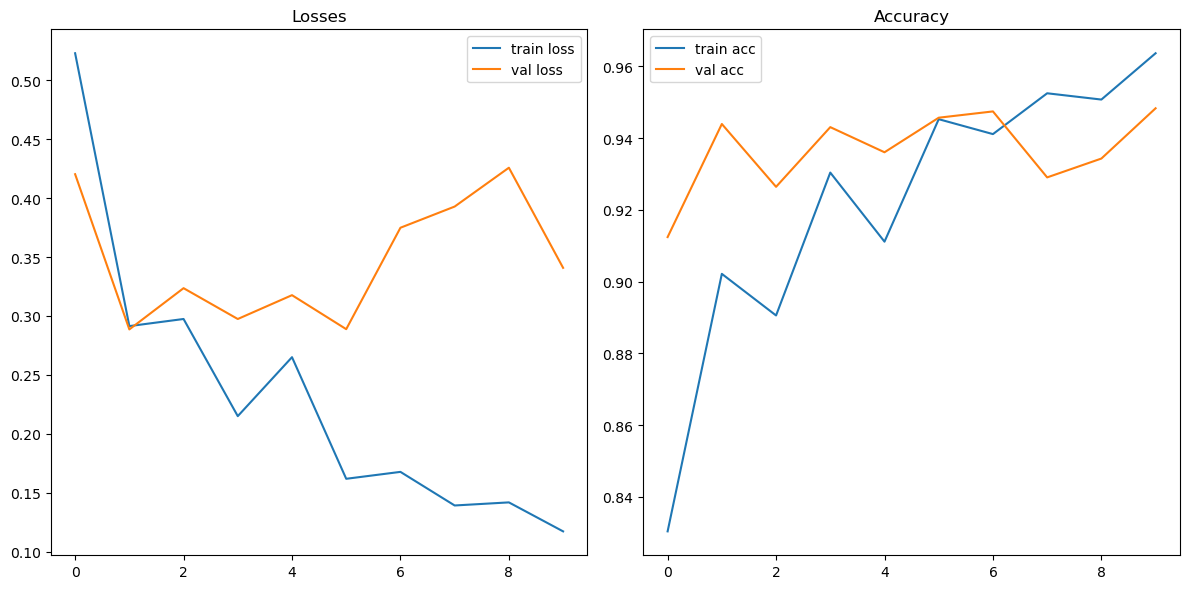

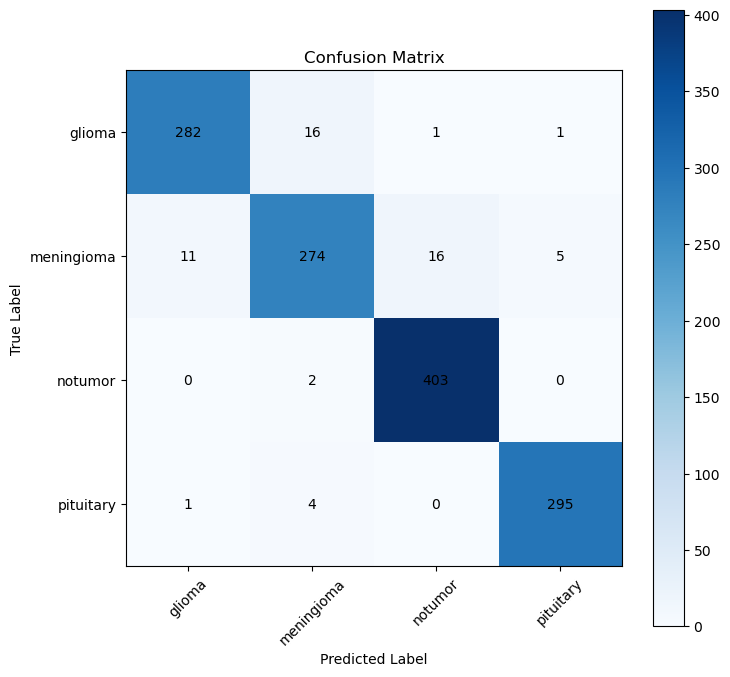

/home/steph/miniconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('brain_tumor_classifier_aug_2.h5')